In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

print(tf.__version__)

1.3.0


## Prediction / regression pipeline

Here we try to predict y(t) based on x(s <= t). y(t) may be x(t+1).

In [2]:
batch_size = 128
d_x = 1
d_y = 1

## Making room for the sequences

Let's create placeholders for our input data x and output data y.

In [3]:
# We do not assume we know the sequence length yet

x_seq_ph = tf.placeholder(shape=(batch_size, None, d_x), dtype=tf.float32)
y_seq_ph = tf.placeholder(shape=(batch_size, None, d_y), dtype=tf.float32)

## Preparing the network's modules

Let's define a convolution layer

In [4]:
def convolution_layer(input_seq, n_dims_in, n_dims_out, width, 
                      dilation=1):
    conv_kernel = tf.get_variable(
        name="kernel",
        shape=[width, n_dims_in, n_dims_out], 
        dtype=tf.float32,
        initializer=tf.truncated_normal_initializer())
    conv_output = tf.nn.convolution(
        input=input_seq,
        filter=conv_kernel,
        padding="SAME",
        strides=None,
        dilation_rate=[dilation]
    )
    return conv_output

## A simple auto-regressive model

Let's build a AR(p) model with tensorflow

In [5]:
p = 3

with tf.variable_scope("AR_p_model"):
    y_predicted = convolution_layer(x_seq_ph, d_x, d_y, width=p)

In [6]:
loss = tf.reduce_sum(tf.nn.l2_loss(y_predicted - y_seq_ph))

In [7]:
learning_rate = 1e-3

optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(loss)

## Pathological example with white noise

In [8]:
def generate_samples(batch_size, sequence_length, n_dims):
    return np.random.normal(0.0, 1.0, (batch_size, sequence_length, n_dims))

## We ask to predict the next value of a white noise process, this should not work with a causal convolution and yet it does here

In [9]:
n_steps = int(1e4)
sequence_length = 128

session = tf.Session()

session.run(tf.global_variables_initializer())

for step in xrange(n_steps):
    x_seq = generate_samples(batch_size, sequence_length + 1, d_x)
    loss_eval, _ = session.run((loss, optimizer), 
                               feed_dict={x_seq_ph: x_seq[:,:-1], 
                                          y_seq_ph: x_seq[:,1:]})

    if not (step % 100): print loss_eval

79385.8
71092.7
64978.8
58998.9
54293.8
49475.7
44630.2
41053.5
36824.9
33193.7
29416.5
27577.5
24059.2
21075.4
18855.3
16548.2
14410.6
12136.9
10405.9
8580.73
7093.55
5476.04
4365.98
3282.61
2346.64
1543.82
956.996
493.608
214.569
69.5313
64.1003
53.0513
50.2537
63.9358
56.1289
52.0867
82.2691
75.3517
46.8064
60.2438
82.043
59.7848
66.6814
67.3402
56.9864
74.4235
68.1859
60.1783
59.5596
55.7858
62.861
46.5053
59.886
53.1552
63.9923
63.5245
58.9556
50.3887
67.7872
62.7261
65.8328
62.5016
58.1204
58.9583
58.126
86.3002
57.7596
64.3403
64.3558
67.5506
51.8623
62.9604
70.25
57.7505
81.1058
80.9933
66.3198
60.8659
65.3493
45.7633
70.9489
52.5485
64.233
82.6858
56.1371
55.5857
51.389
55.6646
68.1088
75.2166
61.445
74.103
79.6774
63.7577
56.6273
63.4769
51.2774
75.135
77.5927
70.5207


In [10]:
variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="AR_p_model")

print([v.name for v in variables])
kernel = [v for v in variables if "kernel" in v.name.split('/')[-1]][0]

kernel_eval = session.run(kernel)

[u'AR_p_model/kernel:0', u'AR_p_model/kernel/RMSProp:0', u'AR_p_model/kernel/RMSProp_1:0']


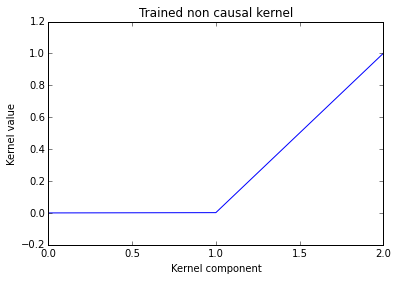

In [11]:
plt.plot(kernel_eval[:,0,0])
plt.title("Trained non causal kernel")
plt.ylabel("Kernel value")
plt.xlabel("Kernel component")
plt.show()